In [82]:
# standard packages
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# statsmodels/auto arima packages
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

# SARIMA modeling packages
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

# RNN packages
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


# visualization packages
import matplotlib.pylab as plt
%matplotlib inline

# model evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

In this notebook we will accomplish several goals:

- Visualize temperature in Boston 1989-2019
- Perform ETS decomposition of temperature in Boston, visualize results
- Fit two models on ~19 years of data, holding out one year for model evaluation
    - Seasonal Auto Regressive Integrated Moving Average (using grid search for model parameters)
    - LSTM
- Visually inspect model fit
- Model evaluation via mean squared error, root-mean squared error and mean-absolute error


In [83]:
boston_noaa_data = pd.read_csv('../../data/clean/boston_clean.csv')

boston_noaa_data['date'] = pd.to_datetime(boston_noaa_data['date'])

boston_noaa_data.set_index('date', inplace = True)

# resampling monthly data
boston_noaa_data = boston_noaa_data.resample(rule = 'M').mean()
boston_noaa_data.index.freq = 'M'

In [4]:
boston_noaa_data.head()

,temp_noaa,dew_noaa,wind_speed_noaa,pressure
date,,,,
1989-01-31,33.798548,18.140968,6.468548,1018.988441
1989-02-28,30.521696,17.649821,6.305952,1020.907440
1989-03-31,36.938871,24.589032,6.465457,1021.862366
1989-04-30,45.220250,31.862750,6.126944,1014.847500
1989-05-31,58.645081,47.469355,5.950403,1014.852554


Plot of monthly temp in Boston, 1989-2019

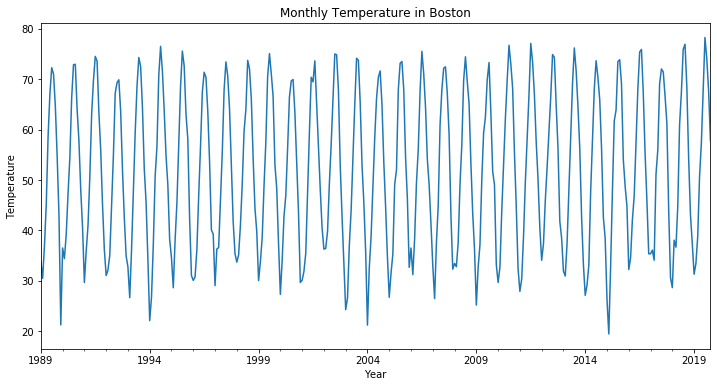

In [5]:
title = 'Monthly Temperature in Boston'
ylabel='Temperature'
xlabel='Year'

ax = boston_noaa_data['temp_noaa'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

# saving plot
plt.savefig("../../visualizations/Boston_Temp.png", quality = 95, dpi = 200)

### ETS Decomposition and Test for Stationarity

Testing for stationarity: constant mean and variance over time.  The plot above supports stationarity, but we will also use the augmented Dickey-Fuller test.

Below is a plot of the orginal data, the 12-month rolling mean and the 12-month rolling standard deviation

In [6]:
rolling_mean = boston_noaa_data['temp_noaa'].rolling(window = 12, center = False).mean()
rolling_std = boston_noaa_data['temp_noaa'].rolling(window = 12, center = False).std()

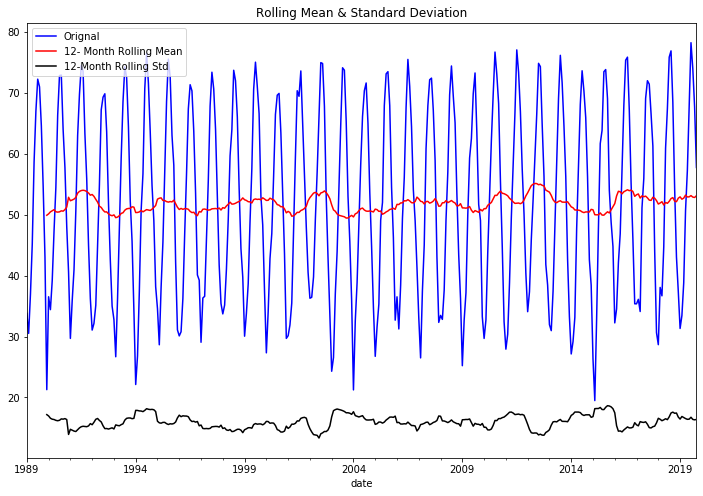

In [7]:
boston_noaa_data['temp_noaa'].plot(color = 'blue', label = 'Orignal', figsize = (12,8))
rolling_mean.plot(color = 'red', label = '12- Month Rolling Mean')
rolling_std.plot(color = 'black', label = '12-Month Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.savefig("../../visualizations/year_rolling_temp.png", quality = 95, dpi = 200);

Performing Error, Trend, Season (ETS) Decomposition

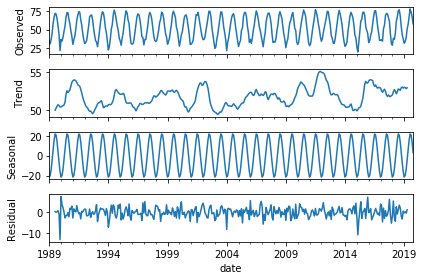

In [8]:
result = seasonal_decompose(boston_noaa_data['temp_noaa'], model='add')
result.plot()
plt.savefig("../../visualizations/ETS_Decomp.png",quality = 95, dpi = 200)

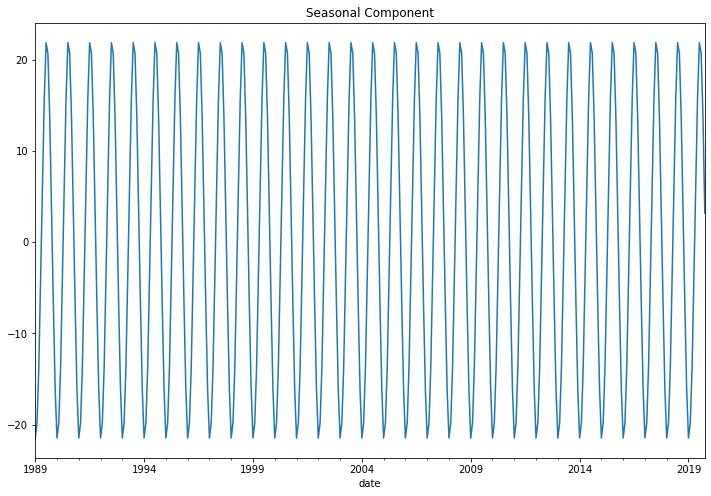

In [9]:
result.seasonal.plot(figsize = (12,8), title = 'Seasonal Component');

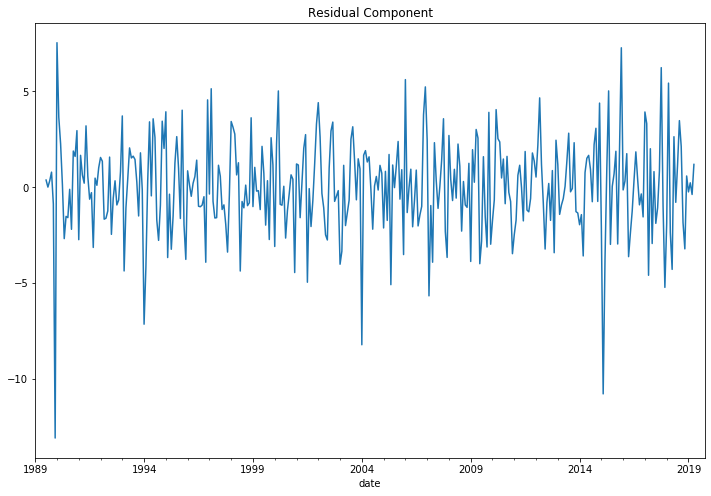

In [10]:
result.resid.plot(figsize = (12,8), title = 'Residual Component');

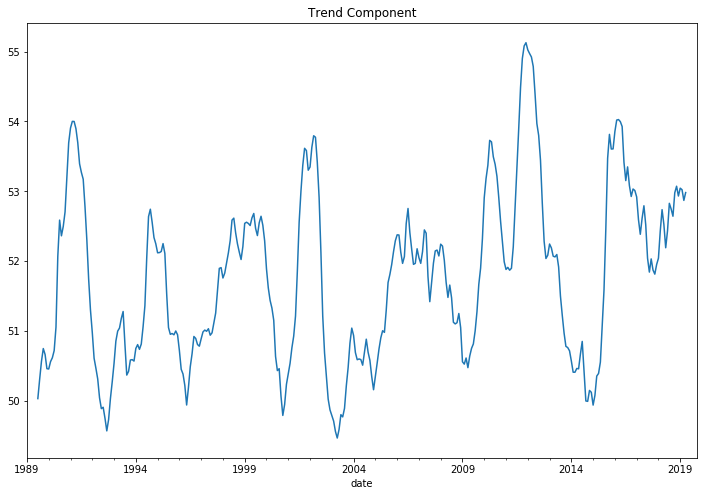

In [11]:
result.trend.plot(figsize = (12,8), title = 'Trend Component');

Augmented Dickey-Fuller Test

Function Source: Udemy, Time Series Analysis in Python

In [12]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [13]:
adf_test(boston_noaa_data['temp_noaa'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -5.784136e+00
p-value                 5.045386e-07
# lags used             1.700000e+01
# observations          3.520000e+02
critical value (1%)    -3.449065e+00
critical value (5%)    -2.869786e+00
critical value (10%)   -2.571163e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Data appears to be stationary based on visual evidence and the augmented Dickey-Fuller Test

### Test/Train Split

We will be forecasting 1 year into the future.  Therefore we will hold out the last year of data to evaluate the three models

In [14]:
len(boston_noaa_data)

370

In [29]:
boston_noaa_data.head()

,temp_noaa,dew_noaa,wind_speed_noaa,pressure
date,,,,
1989-01-31,33.798548,18.140968,6.468548,1018.988441
1989-02-28,30.521696,17.649821,6.305952,1020.907440
1989-03-31,36.938871,24.589032,6.465457,1021.862366
1989-04-30,45.220250,31.862750,6.126944,1014.847500
1989-05-31,58.645081,47.469355,5.950403,1014.852554


In [31]:
train = boston_noaa_data.drop(['dew_noaa', 'wind_speed_noaa', 'pressure'], axis = 1).iloc[:358]
test = boston_noaa_data.drop(['dew_noaa', 'wind_speed_noaa', 'pressure'], axis = 1).iloc[358:]

### SARIMA Model

Using auto arima to select the correct arima and seasonal order parameters

In [26]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(boston_noaa_data['temp_noaa'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Statespace Model Results                            
================================================================================
Dep. Variable:                        y   No. Observations:                  370
Model:             SARIMAX(2, 0, 0, 12)   Log Likelihood               -1023.342
Date:                  Mon, 13 Jan 2020   AIC                           2054.684
Time:                          18:27:44   BIC                           2070.338
Sample:                               0   HQIC                          2060.902
                                  - 370                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.1851      0.358      6.111      0.000       1.484       2.886
ar.S.L12       0.4632      0.031     14.746      0.000       0.402       0.525
ar.S.L24       0.4944      0.033     14.899      0.000       0.429       0.559
sigma2        12.3943      0.701     17.692      0.000      11.021      13.767
===================================================================================
Ljung-Box (Q):                      148.39   Jarque-Bera (JB):                13.44
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                            -0.16
Prob(H) (two-sided):                  0.60   Kurtosis:                         3.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This provides an ARIMA Order of (1,0,2) with seasonal order (1, 0, 1, 12)

In [17]:
model = SARIMAX(train['temp_noaa'],order=(1,0,2), seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          temp_noaa   No. Observations:                  358
Model:             SARIMAX(1, 0, 2)x(1, 0, 1, 12)   Log Likelihood                -929.622
Date:                            Mon, 13 Jan 2020   AIC                           1871.244
Time:                                    18:24:13   BIC                           1894.527
Sample:                                01-31-1989   HQIC                          1880.504
                                     - 10-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9787      0.019     52.380      0.000       0.942       1.015
ma.L1         -0.6762      0.055    -12.380      0.000      -0.783      -0.569
ma.L2         -0.1641      0.053     -3.103      0.002      -0.268      -0.060
ar.S.L12       0.9993      0.001   1842.702      0.000       0.998       1.000
ma.S.L12      -0.8603      0.045    -19.100      0.000      -0.949      -0.772
sigma2         9.2172      0.591     15.601      0.000       8.059      10.375
===================================================================================
Ljung-Box (Q):                       37.82   Jarque-Bera (JB):                29.06
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -0.17
Prob(H) (two-sided):                  0.88   Kurtosis:                         4.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1

predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,0,2)x(1,0,1,12) Predictions')

[Text(0, 0.5, 'Temperature'), Text(0.5, 0, 'Year')]

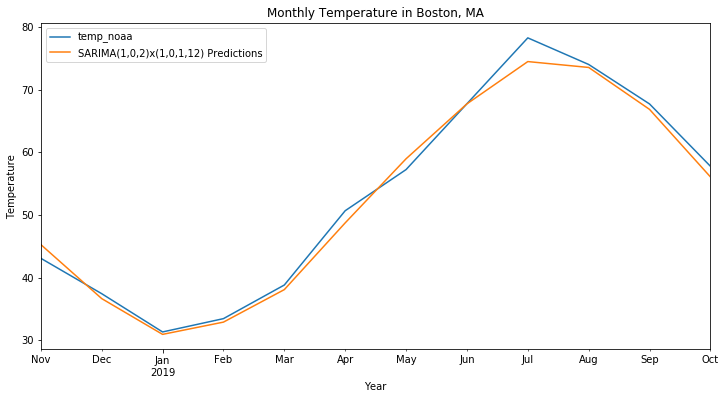

In [21]:
# Plot predictions against known values
title = 'Monthly Temperature in Boston, MA'
ylabel='Temperature'
xlabel='Year'

ax = test['temp_noaa'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

Saving predicted values from SARIMA to test dataset for future evaluation

In [54]:
test['SARIMA_predictions'] = predictions

### LSTM Model

First scaling the train data via MinMax scaler

In [33]:
scaler = MinMaxScaler()

scaler.fit(train)

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

Creating a time series generator to provide training sequnces to the RNN

In [34]:
# define generator
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

Creating the LSTM

We will use a simple model structure: one LSTM layer with relu activation.  We will use mean squared error loss to train.

In [46]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


Training model for 10 epochs

In [48]:
model.fit_generator(generator,epochs=10)

Epoch 1/10
346/346 [==============================] - 16s 46ms/step - loss: 0.0586
Epoch 2/10
346/346 [==============================] - 13s 38ms/step - loss: 0.0090
Epoch 3/10
346/346 [==============================] - 12s 34ms/step - loss: 0.0041
Epoch 4/10
346/346 [==============================] - 10s 29ms/step - loss: 0.0050
Epoch 5/10
346/346 [==============================] - 10s 30ms/step - loss: 0.0047
Epoch 6/10
346/346 [==============================] - 11s 31ms/step - loss: 0.0060
Epoch 7/10
346/346 [==============================] - 10s 28ms/step - loss: 0.0039
Epoch 8/10
346/346 [==============================] - 12s 36ms/step - loss: 0.0042
Epoch 9/10
346/346 [==============================] - 11s 32ms/step - loss: 0.0039
Epoch 10/10
346/346 [==============================] - 11s 32ms/step - loss: 0.0048


Examining model loss during training epochs

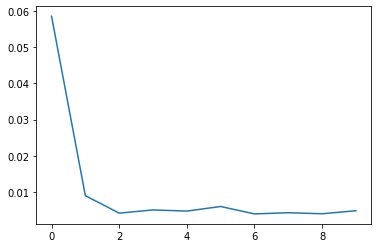

In [49]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)


Creating loop to generate predictions on test data

In [50]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

Inverting the MinMax scaler on test predicitons to plot predicted values

In [51]:
test['LSTM_predictions'] = scaler.inverse_transform(test_predictions)

Visualizing real values as well as predicted temperature values for the SARIMAX and LSTM models

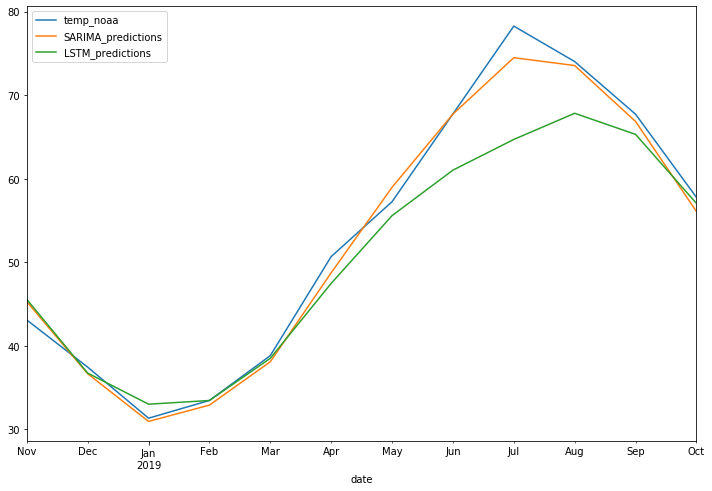

In [70]:
test[['temp_noaa', 'SARIMA_predictions', 'LSTM_predictions']].plot(figsize = (12,8))
plt.savefig("../../visualizations/models_test.png", dpi = 200, quality = 95)

Based on the plot above, it appears the SARIMA model is a better fit to the data.

Model evaluation: MSE, RMSE, MAE

In [56]:
sarima_mse = mean_squared_error(test['temp_noaa'], test['SARIMA_predictions'])
lstm_mse = mean_squared_error(test['temp_noaa'], test['LSTM_predictions'])

print(f'SARIMA(1,0,2)(1,0,1,12) MSE Error: {sarima_mse:11.10}')
print(f'LSTM MSE Error: {lstm_mse:11.10}')

SARIMA(1,0,2)(1,0,1,12) MSE Error: 2.610427143
LSTM MSE Error: 24.70813414


In [58]:
sarima_rmse = np.sqrt(sarima_mse)
lstm_rmse = np.sqrt(lstm_mse)

print(f'SARIMA(1,0,2)(1,0,1,12) RMSE Error: {sarima_rmse:11.10}')
print(f'LSTM RMSE Error: {lstm_rmse:11.10}')

SARIMA(1,0,2)(1,0,1,12) RMSE Error: 1.615681634
LSTM RMSE Error: 4.970727727


One key difference between MSE and RMSE: RMSE is in the orginal unit of the value being predicted.  Therefore we observe that on average the SARIMA model is off about 1.62 degrees, while the LSTM is off by about 4.97 degrees

In [59]:
sarima_mae = mean_absolute_error(test['temp_noaa'], test['SARIMA_predictions'])
lstm_mae = mean_absolute_error(test['temp_noaa'], test['LSTM_predictions'])

print(f'SARIMA(1,0,2)(1,0,1,12) MAE Error: {sarima_mae:11.10}')
print(f'LSTM MAE Error: {lstm_mae:11.10}')

SARIMA(1,0,2)(1,0,1,12) RMSE Error: 1.263353927
LSTM RMSE Error: 3.305837981


Based on MSE/RMSE and MAE, we would move forward with the SARIMA model

### Forecasting temperature in Boston the next 12 months

Using our model, we will first retrain on the full dataset, and then forecat monthly temperature in 2020

In [85]:
model = SARIMAX(boston_noaa_data['temp_noaa'], order = (1,0,2), seasonal_order=(1,0,1,12))

results = model.fit()

forecast = results.predict(start = len(boston_noaa_data), end = len(boston_noaa_data) + 11, typ = 'levels').rename('SARIMA(1,0,2)(1,0,1,12) Forecast')

Plotting forecast with historical data

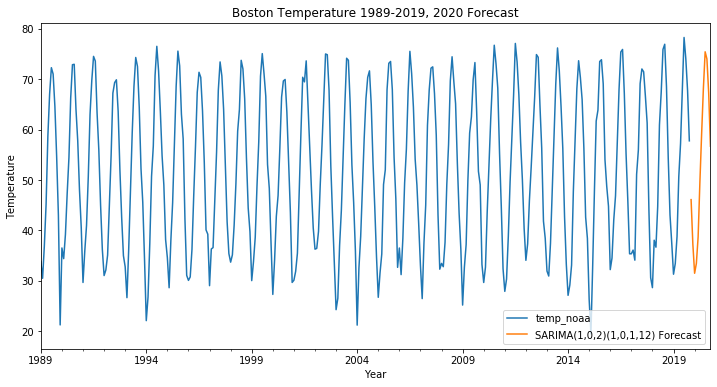

In [86]:
title = 'Boston Temperature 1989-2019, 2020 Forecast'
ylabel='Temperature'
xlabel='Year'

ax = boston_noaa_data['temp_noaa'].plot(legend=True,figsize=(12,6),title=title)
forecast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

plt.savefig("../../visualizations/2020_Forecast.png", quality = 95, dpi = 200);